In [240]:
import pandas as od
import numpy as np
import math
import time

from hurst import compute_Hc
from ou_process import*

from core_io import *

from Backtesters import *
from UnivarTrendStrategies import *
import statsmodels.api as sm
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

import warnings

warnings.filterwarnings('ignore')

plt.style.use('seaborn')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
data = pd.read_csv('strategy_data_lobniv.csv', index_col= 0, parse_dates = True)
quotes = pd.read_pickle('outfile')


qset = pd.DataFrame(quotes)
qset.columns = ['delivery_time', 'order_book']
qset.set_index('delivery_time', drop = True, inplace = True)
qset['niv'] = data.niv[qset.index[0]: qset.index[-1]]
qset['imb'] = data.imb[qset.index[0]: qset.index[-1]]

# Spread Scalper Strategy based on NIV and Imbalance prices Trends

**Abstract** In the following we present an event driven backtesting of an active market trading strategy based on the direction of the NIV and the imbalance prices. The strategy backtest starts from the end of July until the 4th of October.

## Introduction.

The general strategy is based on the previous trend on the NIV in the UK intraday power market. After a thorough research into machine learning models and probabilistic forecasting by means of quantile regressions techniques, we can asses that the best predictor of the direction of the NIV is indeed its previous lag. Namely, a well tuned machine learning probabilistic model would asses a 64% accuracy in predicting the direction of the NIV, whereas one hour lag asses a 70% accuracy in predicting the direction. Neverhteless, such accuracy could be further enhanced by looking at the *distribution* of the NIV and see on which probability buckets (a.k.a. quantiles) the lag predictor works best.

In the first picture below we show that the best predictor for the market direction is simply the NIV. The line is computed on actual data and on imbalance to vwap.

STRATEGY PERFORMANCE
Terminal Wealth: 442918.31
Return on Investment: 42.34 per MW
--------------------------------------------------------------------------------
Average total return: 42.34
--------------------------------------------------------------------------------
Average Gain: 42.34
Average Loss: nan
--------------------------------------------------------------------------------
Hit Rate: 1.0000
Loss Rate: 0.0000
--------------------------------------------------------------------------------
Expectancy: nan
Max Drawdown: -468.30
--------------------------------------------------------------------------------
Sharpe Ratio: 0.87


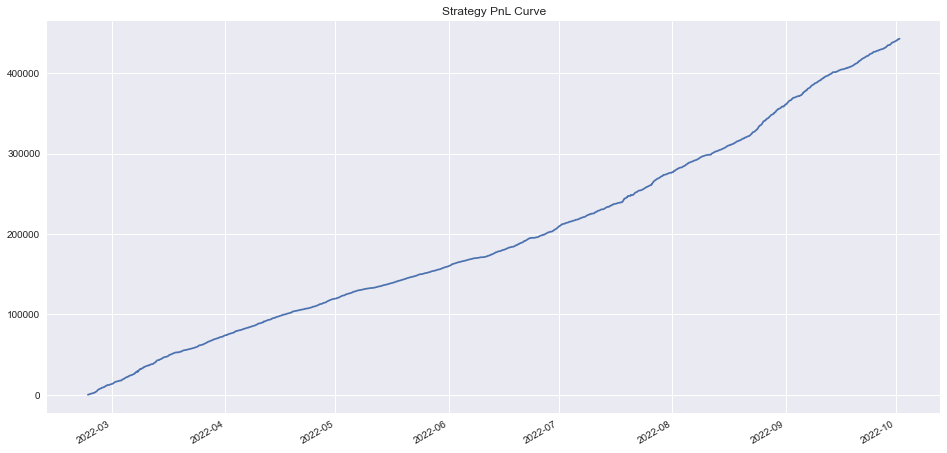

In [3]:
nivslider = NivSlider(data=data)
nivslider.test_strategy(k = 0, delivery_distance=1)

From the above graph we can see that also the knowledge of the imbalance price in advance is a potential predictor of the levels where the market is trading. Being the imbalance price the cash out of each single contract that we wish to trade, the market prices converges towards that price approaching delivery, and of course at delivery.

## Some key analysis on the NIV

- Overall 70% accuracy on guessing the direction from the lags.
- In some probability buckets the accuracy is greater than 70% (on the historical sample)

In [4]:
def direction_accuracy(data: pd.DataFrame, k:int) -> float:
    
    df = data.copy()
    df[f'lag_{k}'] = data.niv.shift(k)
    df.dropna(inplace=True)
    
    df['niv_sign'] = np.sign(df.niv)
    df['lag_sign'] = np.sign(df[f'lag_{k}'])
    
    accuracy = df.query(f'niv_sign == lag_sign').shape[0] / df.shape[0]
    
    return round(accuracy,2)

In [5]:
print('Accuracy direction summary')
print('='*80)
print('Overall Accuracy direction lag 2: {:.2f}'.format(direction_accuracy(data, k=2)))
print('-'*80)
print('Overall Accuracy direction lag 3: {:.2f}'.format(direction_accuracy(data, k=3)))
print('-'*80)
print('Overall Accuracy lag 4: {:.2f}'.format(direction_accuracy(data, k=4)))
print('='*80)

Accuracy direction summary
Overall Accuracy direction lag 2: 0.70
--------------------------------------------------------------------------------
Overall Accuracy direction lag 3: 0.64
--------------------------------------------------------------------------------
Overall Accuracy lag 4: 0.62


The accuracy follows a power law decay

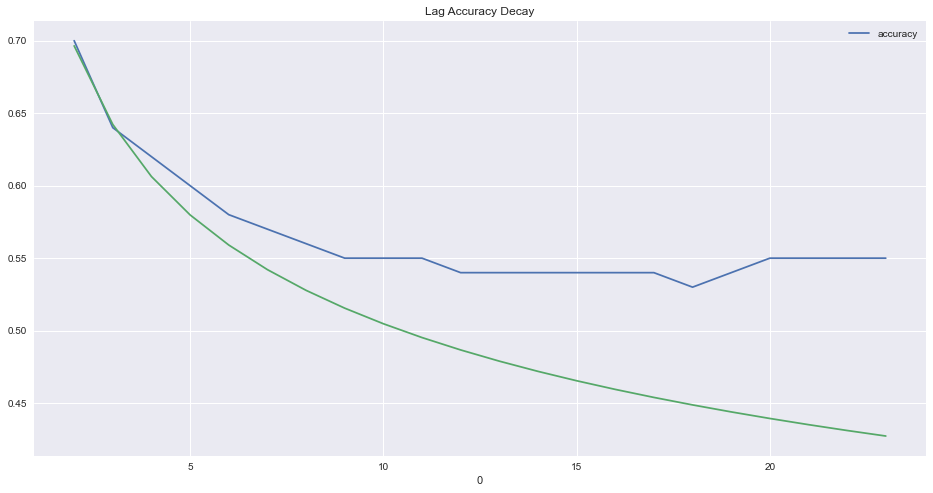

In [6]:
def decay(x:np.array, power:float)->float:
    return 1 / x**power

accuracy_curve = []

for k in range(2,24):
    accuracy_curve.append((k, direction_accuracy(data=data, k = k)))
    
ds = pd.DataFrame(accuracy_curve).set_index(0)
ds.columns = ['accuracy']

mae = []

power_range = np.arange(0.1, 1, 0.1)

for power in power_range:
    
    fun = decay(x = ds.index, power=power)
    delta = abs(fun - ds.accuracy.values)
    avgdelta = np.average(delta)
    mae.append((power, avgdelta))
    
pd.DataFrame(mae).set_index(0).idxmin()


ds = pd.DataFrame(accuracy_curve).set_index(0)
ds.columns = ['accuracy']
ds.plot(figsize=(16,8), title = 'Lag Accuracy Decay')
plt.plot(0.8*decay(pd.Series(np.array(accuracy_curve).T[0], index = ds.index), power=float(pd.DataFrame(mae).set_index(0).idxmin().values)))


In [16]:
quantiles = [0.05, 0.25, 0.5, 0.75, 0.95]

q = data.niv.quantile(quantiles)

df = data.niv.to_frame('niv')

central_slice = df.query(f'niv >= {q[0.25]} & niv <= {q[0.75]}')


print('Accuracy direction summary at the Center of the Distribution')
print('='*80)
print('Overall Accuracy direction lag 2: {:.2f}'.format(direction_accuracy(central_slice, k=2)))
print('-'*80)
print('Overall Accuracy direction lag 3: {:.2f}'.format(direction_accuracy(central_slice, k=3)))
print('-'*80)
print('Overall Accuracy lag 4: {:.2f}'.format(direction_accuracy(central_slice, k=4)))
print('='*80)

Accuracy direction summary at the Center of the Distribution
Overall Accuracy direction lag 2: 0.53
--------------------------------------------------------------------------------
Overall Accuracy direction lag 3: 0.52
--------------------------------------------------------------------------------
Overall Accuracy lag 4: 0.52


In [ ]:
central_slice = df.query(f'niv >= {q[0.5]} & niv <= {q[0.75]}')


print('Accuracy direction summary at the Center of the Distribution')
print('='*80)
print('Overall Accuracy direction lag 2: {:.2f}'.format(direction_accuracy(central_slice, k=2)))
print('-'*80)
print('Overall Accuracy direction lag 3: {:.2f}'.format(direction_accuracy(central_slice, k=3)))
print('-'*80)
print('Overall Accuracy lag 4: {:.2f}'.format(direction_accuracy(central_slice, k=4)))
print('='*80)

<AxesSubplot:>

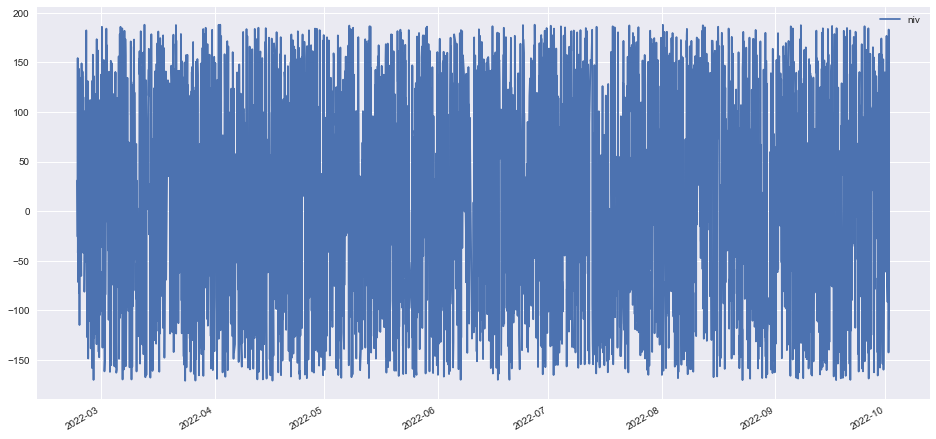

In [18]:
central_slice.plot(figsize=(16,8))

In [190]:
skew_neg_slice = df.query(f'niv >= {q[0.05]} & niv <= {q[0.75]}')


print('Accuracy direction summary at the Interquantile skew negative')
print('='*80)
print('Overall Accuracy direction lag 2: {:.2f}'.format(direction_accuracy(skew_neg_slice, k=2)))
print('-'*80)
print('Overall Accuracy direction lag 3: {:.2f}'.format(direction_accuracy(skew_neg_slice, k=3)))
print('-'*80)
print('Overall Accuracy lag 4: {:.2f}'.format(direction_accuracy(skew_neg_slice, k=4)))
print('='*80)

Accuracy direction summary at the Interquantile skew negative
Overall Accuracy direction lag 2: 0.61
--------------------------------------------------------------------------------
Overall Accuracy direction lag 3: 0.57
--------------------------------------------------------------------------------
Overall Accuracy lag 4: 0.57


In [189]:
skew_pos_slice = df.query(f'niv >= {q[0.25]} & niv <= {q[0.95]}')


print('Accuracy direction summary at the Interquantile skew positive')
print('='*80)
print('Overall Accuracy direction lag 2: {:.2f}'.format(direction_accuracy(skew_pos_slice, k=2)))
print('-'*80)
print('Overall Accuracy direction lag 3: {:.2f}'.format(direction_accuracy(skew_pos_slice, k=3)))
print('-'*80)
print('Overall Accuracy lag 4: {:.2f}'.format(direction_accuracy(skew_pos_slice, k=4)))
print('='*80)

Accuracy direction summary at the Interquantile skew positive
Overall Accuracy direction lag 2: 0.63
--------------------------------------------------------------------------------
Overall Accuracy direction lag 3: 0.60
--------------------------------------------------------------------------------
Overall Accuracy lag 4: 0.60


In [24]:
df['dir'] = np.sign(df.niv)

df['consecutive'] = df.dir.groupby((df.dir != df.dir.shift()).cumsum()).transform('size') * df.dir


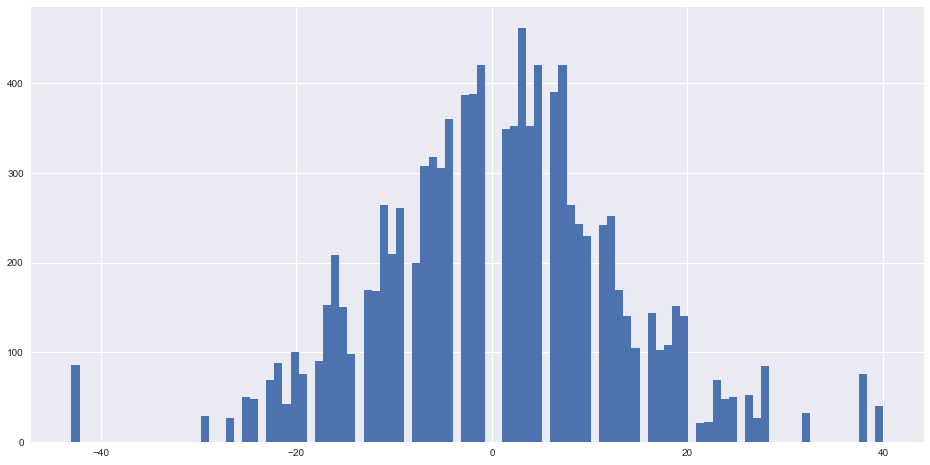

In [25]:
plt.figure(figsize=(16,8))

plt.hist(df.consecutive, bins=100)


plt.show()

<AxesSubplot:>

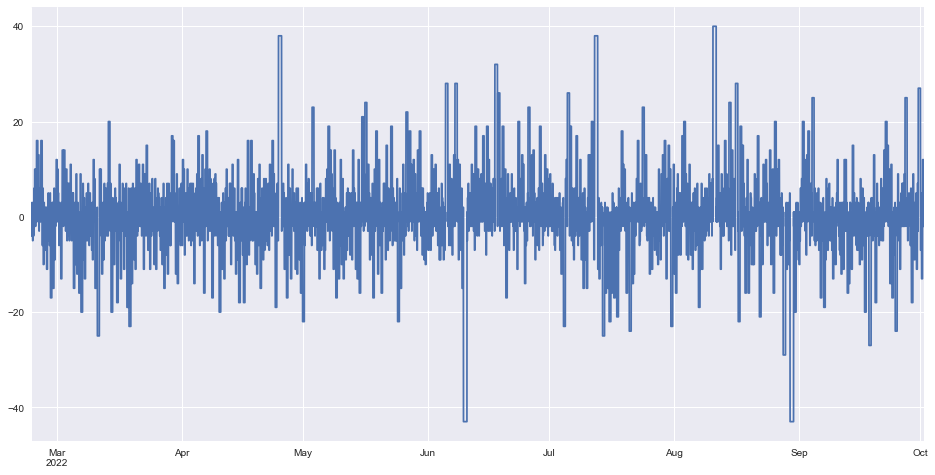

In [14]:
df.consecutive.plot(figsize=(16,8))

In [80]:
hurst_exp = compute_Hc(df.niv)[0]
mean_rev_param = estimate_OU_params(df.niv.values)
half_life = np.log(2) / mean_rev_param.alpha


print('Fundamental Characteristics of the Process')
print('='*80)
print('Hurst Exponent: {:.2f}'.format(hurst_exp))
print('-'*80)
print('Mean Reversion Parameter: {:.2f}'.format(mean_rev_param.alpha))
print('-'*80)
print('Half life of Mean Reversion: {:.2f}'.format(half_life))
print('='*80)


Fundamental Characteristics of the Process
Hurst Exponent: 0.23
--------------------------------------------------------------------------------
Mean Reversion Parameter: 0.21
--------------------------------------------------------------------------------
Half life of Mean Reversion: 3.24


PERFORMANCE METRICS
Terminal Wealth: 28939.26
--------------------------------------------------------------------------------
Return on investment: 2.77
--------------------------------------------------------------------------------
Sharpe Ratio: 0.04
--------------------------------------------------------------------------------
Hit Rate: 0.50


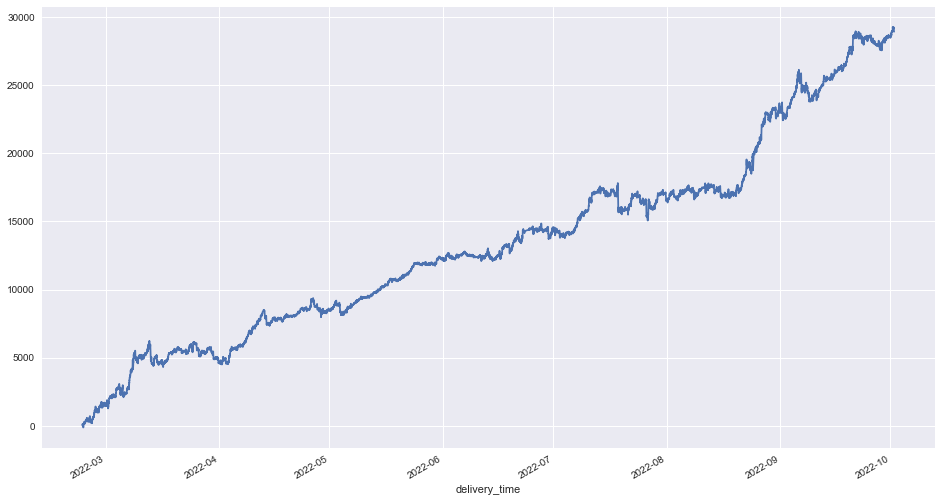

In [185]:
bkt = data[['wap1', 'imb']].copy()
bkt['price'] = bkt.imb.sub(bkt.wap1)

bkt['dir'] = np.sign(data.niv.shift(2))
bkt['consecutive'] = dg.consecutive



bkt.dropna(inplace=True)

cashflow = 0
position = 0

rec = []


for layer in range(len(bkt)):
    
    if bkt.dir.iloc[layer] > 0:
        
        cashflow += -(bkt.price.iloc[layer])
        position = 1
        rec.append((bkt.index[layer], bkt.price.iloc[layer], position, bkt.consecutive.iloc[layer], bkt.dir.iloc[layer]))
        
        
            
        
    elif bkt.dir.iloc[layer] < 0:
        
        cashflow += (bkt.price.iloc[layer])
        position = -1
        rec.append((bkt.index[layer],bkt.price.iloc[layer], position, bkt.consecutive.iloc[layer], bkt.dir.iloc[layer]))
        
        
bt = pd.DataFrame(rec)

bt.columns = ['delivery_time', 'traded_price', 'position', 'consecutive', 'dir']

bt.set_index('delivery_time', drop = True, inplace = True)

bt['returns'] = bt.traded_price.shift(1) - bt.traded_price
bt['strategy'] = bt.returns * bt.position.shift(1)
bt['total_return'] = bt.strategy.cumsum()

bt.total_return.plot(figsize=(16,9))

print('PERFORMANCE METRICS')
print('='*80)
print('Terminal Wealth: {:.2f}'.format(bt.total_return[-1]))
print('-'*80)
print('Return on investment: {:.2f}'.format(bt.total_return[-1]/len(bt)))
print('-'*80)
print('Sharpe Ratio: {:.2f}'.format(bt.strategy.mean()/bt.strategy.std()))
print('-'*80)
print('Hit Rate: {:.2f}'.format(bt.query('strategy > 0').shape[0]/len(bt)))
print('='*80)

PERFORMANCE METRICS
Terminal Wealth: 27212.96
--------------------------------------------------------------------------------
Return on investment: 2.55
--------------------------------------------------------------------------------
Sharpe Ratio: 0.03
--------------------------------------------------------------------------------
Hit Rate: 0.49


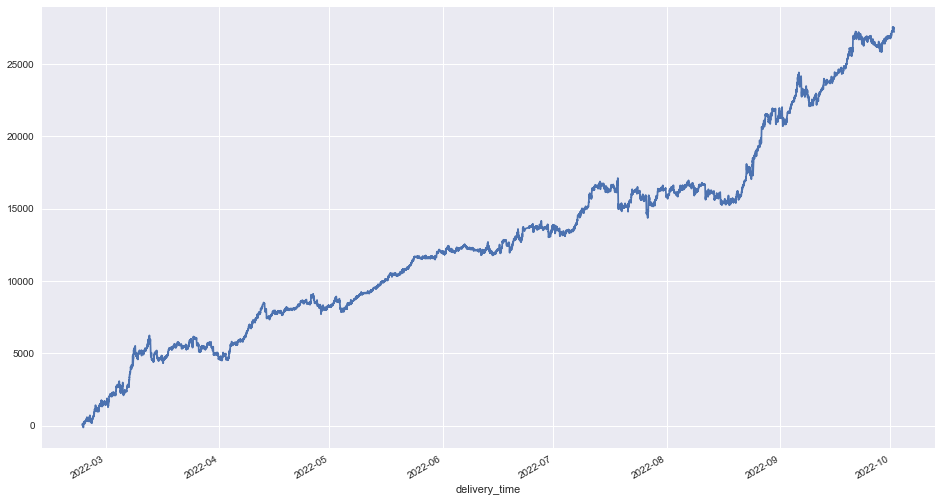

In [191]:
is_3shold = 30

memory = 0
position = 0
cashflow = 0

rec = []


for layer in range(len(bkt)):
    
    if bkt.dir.iloc[layer] > 0:
        
        cashflow += -(bkt.price.iloc[layer])
        position = 1
        rec.append((bkt.index[layer], bkt.price.iloc[layer], position, bkt.consecutive.iloc[layer], bkt.dir.iloc[layer]))
        
        if (abs(bkt.consecutive.iloc[layer]) > is_3shold):
            
            cashflow += (bkt.price.iloc[layer])
            position = -1
            rec.append((bkt.index[layer],bkt.price.iloc[layer], position, bkt.consecutive.iloc[layer], bkt.dir.iloc[layer]))
        
        else:
            pass
            
        
    elif bkt.dir.iloc[layer] < 0:
        
        cashflow += (bkt.price.iloc[layer])
        position = -1
        rec.append((bkt.index[layer],bkt.price.iloc[layer], position, bkt.consecutive.iloc[layer], bkt.dir.iloc[layer]))
        
        if (abs(bkt.consecutive.iloc[layer]) > is_3shold):
            
            cashflow += -(bkt.price.iloc[layer])
            position = 1
            rec.append((bkt.index[layer], bkt.price.iloc[layer], position, bkt.consecutive.iloc[layer], bkt.dir.iloc[layer]))
        
        else:
            pass    
        
        
bt = pd.DataFrame(rec)

bt.columns = ['delivery_time', 'traded_price', 'position', 'consecutive', 'dir']

bt.set_index('delivery_time', drop = True, inplace = True)

bt['returns'] = bt.traded_price.shift(1) - bt.traded_price
bt['strategy'] = bt.returns * bt.position.shift(1)
bt['total_return'] = bt.strategy.cumsum()

bt.total_return.plot(figsize=(16,9))

print('PERFORMANCE METRICS')
print('='*80)
print('Terminal Wealth: {:.2f}'.format(bt.total_return[-1]))
print('-'*80)
print('Return on investment: {:.2f}'.format(bt.total_return[-1]/len(bt)))
print('-'*80)
print('Sharpe Ratio: {:.2f}'.format(bt.strategy.mean()/bt.strategy.std()))
print('-'*80)
print('Hit Rate: {:.2f}'.format(bt.query('strategy > 0').shape[0]/len(bt)))
print('='*80)

## The Spread Scalper Algorithm

## The Spread Scalper Algorithm Version 1.0


- Indicator function:

$$ I(t, Niv_t, Iprice_t, \theta ) = (Niv_{t - \theta}, Iprice_{t - \theta}) : = (I_1, I_2)$$

- Response function:

    $$ R(I, X_t, \phi) : $$

    given $I_1 > \phi_1:$ 

    if at time $t, X_t$ is not filled and $bestAskPrice(t) + \phi_3 \leq I_2$:
                BUY(bestAskPrice(t), qty = 1 MW)

    if at time $t', X_{t'}$ with $t < t'$ is filled with a buy order and $bestAskPrice(t) < bestBidPrice(t') + \phi_4$:
                    SELL(bestBidPrice(t'), qty = -1 MW)

    else return

    else pass

    given $I_1 < \phi_2$

    if at time $t, X_t$ is not filled and $bestBidPrice(t) - \phi_3 \leq I_2$:
                SELL(bestBidPrice(t), qty = - 1 MW)

    if at time $t', X_{t'}$ with $t < t'$ is filled with a sell order and $bestAskPrice(t') < bestBidPrice(t) + \phi_4$:
                    BUY(bestAskPrice(t'), qty = 1MW) 

    else return

    else pass

    LIQUIDATE ANY ORDER BEFORE DELIVERY

    Where $\phi_1, \phi_2$ are some NIV thresholds; $\phi_3, \phi_4$ are the difference from the imbalance price and the profit target respectively 



PERFORMANCE METRICS
Terminal Wealth: 8683.77
--------------------------------------------------------------------------------
Sharpe Ratio: 0.07
--------------------------------------------------------------------------------
Sortino Ratio: 0.56
--------------------------------------------------------------------------------
Hit Rate: 0.61 | Density 0.82
--------------------------------------------------------------------------------
# Trades: 2592 | Wins: 1575 | Losses: 1017
--------------------------------------------------------------------------------
Average Return: 3.35
--------------------------------------------------------------------------------
Median Return: 2.17
--------------------------------------------------------------------------------
Standard Deviation of Returns: 49.24
--------------------------------------------------------------------------------
HHI: 0.08 | HHI plus: 0.00 | HHI minus: 0.00
------------------------------------------------------------------------

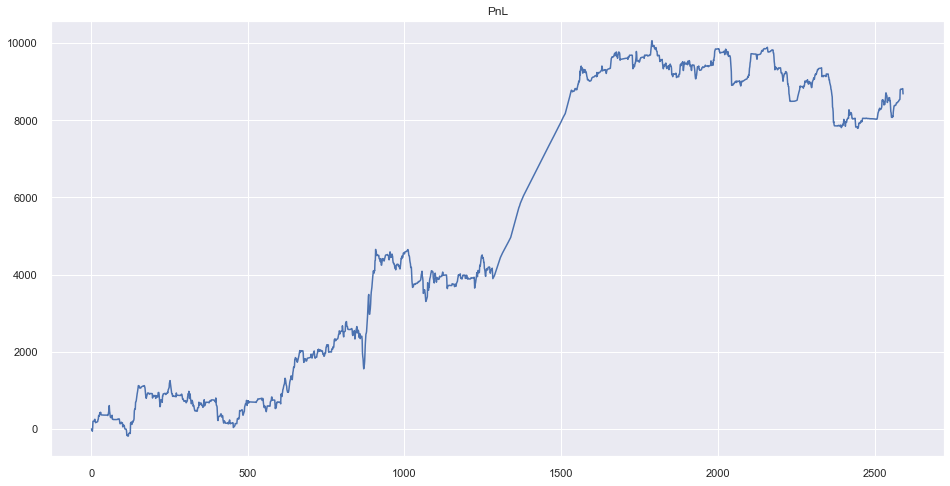

In [266]:
# Parameters

k = 2
commissions = 0.025
premium = 1.025
price_convergence = 40
niv_upper_threshold = data.niv.quantile(.8)
niv_lower_threshold = data.niv.quantile(.2)
target_price = 0

# Algo Trackers


cashflow = 0
position = 0
trades = 0
record_trade = 0

cashflow_tracker = []
logger = []
logger_list = []

# on_data

dataset = qset.copy()
dataset['lag_niv'] = dataset.niv.shift(k)
dataset['lag_imb'] = dataset.imb.shift(k)
dataset.dropna(inplace=True)

deliveries = dataset.index


# Core Algo Rules

for delivery_time in deliveries:
    
    indicator = [dataset.lag_niv[str(delivery_time)], dataset.lag_imb[str(delivery_time)]]
    actuals = [dataset.niv[str(delivery_time)], dataset.imb[str(delivery_time)]]
    order_book = dataset.order_book[str(delivery_time)].dropna().copy()
    
    
    # Selling Rule
    
    if (indicator[0] < 0) & (indicator[0] <= niv_lower_threshold):
    
        for layer in range(len(order_book)-1):
            
            if (order_book.bid.iloc[layer] >= target_price) & (order_book.ask.iloc[layer] >= target_price):
                 
            
            
                if (position == 0) & (order_book.bid.iloc[layer] - price_convergence > indicator[1]): 
                    
                    cashflow += (order_book.bid.iloc[layer] + commissions)
                    position = -1
                    trades += 1
                    record_trade = layer
                    
                    logger.append('Sold 1MW at {:.2f} | delivery time is {} | traded time {} '.format(order_book.bid.iloc[layer], delivery_time, order_book.index[layer]))
                    #print('Sold 1MW at {:.2f} | delivery time is {} | traded time {} '.format(order_book.bid.iloc[layer], delivery_time, order_book.index[layer]))
                    #time.sleep(0.005)
                    logger_list.append((order_book.bid.iloc[layer], cashflow, delivery_time, order_book.index[layer], -1, position, indicator[0], indicator[1], actuals[0], actuals[1]))            
                    
                elif position == -1: 
                    
                    if (record_trade != 0) & (order_book.bid.iloc[record_trade] > (order_book.ask.iloc[layer] + premium)):
            
                        cashflow += - (order_book.ask.iloc[layer] + commissions)
                        position = 0
                        trades += 1
                        
                        logger.append('Bought 1MW at {:.2f} | delivery time is {} | traded time {}'.format(order_book.ask.iloc[layer], delivery_time, order_book.index[layer]))
                        #print('Bought 1MW at {:.2f} | delivery time is {} | traded time {}'.format(order_book.ask.iloc[layer], delivery_time, order_book.index[layer]))
                        #time.sleep(0.005)
                        logger_list.append((order_book.ask.iloc[layer], cashflow, delivery_time, order_book.index[layer], 1, position, indicator[0], indicator[1], actuals[0], actuals[1]))
                        
                    else:
                        pass
            
            else:
                
                pass  
            
    # Buying Rule      
                    
    elif (indicator[0] > 0) & (indicator[0] >= niv_upper_threshold):
        
        for layer in range(len(order_book)-1):
            
            if (order_book.bid.iloc[layer] >= target_price) & (order_book.ask.iloc[layer] >= target_price):
                
            
            
                if (position == 0) & (order_book.ask.iloc[layer] + price_convergence  < indicator[1]): 
                    
                    cashflow += -(order_book.ask.iloc[layer] + commissions)
                    position = 1
                    trades += 1
                    record_trade = layer
                    
                    logger.append('Bought 1MW at {:.2f} | delivery time is {} | traded time {}'.format(order_book.ask.iloc[layer], delivery_time, order_book.index[layer]))
                    #print('Bought 1MW at {:.2f} | delivery time is {} | traded time {}'.format(order_book.ask.iloc[layer], delivery_time, order_book.index[layer]))
                    #time.sleep(0.005)
                    logger_list.append((order_book.ask.iloc[layer], cashflow, delivery_time, order_book.index[layer], 1, position, indicator[0], indicator[1], actuals[0], actuals[1]))
                    
                        
                        
                elif position == 1:
                    
                
                    if (record_trade != 0) & (order_book.ask.iloc[record_trade] < order_book.bid.iloc[layer] + premium):
                    
                        cashflow += (order_book.bid.iloc[layer] + commissions)
                        position = 0
                        trades += 1
                        
                        logger.append('Sold 1MW at {:.2f} | delivery time is {} | traded time {}'.format(order_book.bid.iloc[layer], delivery_time, order_book.index[layer]))
                        #print('Sold 1MW at {:.2f} | delivery time is {} | traded time {}'.format(order_book.bid.iloc[layer], delivery_time, order_book.index[layer]))
                        #time.sleep(0.005)
                        logger_list.append((order_book.bid.iloc[layer], cashflow, delivery_time, order_book.index[layer], -1, position, indicator[0], indicator[1], actuals[0], actuals[1]))
                        
                    else:
                        pass
                    
            else:
                pass 

    
    # Brute Force Liquidation at delivery (no cash-out)
                    
    if (position == 1): 
            
        cashflow += (order_book.bid.iloc[layer] + commissions)
        position = 0
        trades += 1
        
        logger.append('Sold 1MW at {:.2f} | delivery time is {} | traded time {}'.format(order_book.bid.iloc[layer], delivery_time, order_book.index[layer]))
        #print('1MW is Liquidated at {:.2f} | delivery time is {} | traded time {}'.format(order_book.bid.iloc[layer], delivery_time, order_book.index[layer]))
        #time.sleep(0.5)
        logger_list.append((order_book.bid.iloc[layer], cashflow, delivery_time, order_book.index[layer], -1, position, indicator[0], indicator[1], actuals[0], actuals[1]))
            
    elif position == -1: 
            
        cashflow += -(order_book.ask.iloc[layer] + commissions)
        position = 0
        trades += 1
        
        logger.append('Bought 1MW at {:.2f} | delivery time is {} | traded time {}'.format(order_book.ask.iloc[layer], delivery_time, order_book.index[layer]))
        #print('1MW is Liquidated at {:.2f} | delivery time is {} | traded time {}'.format(order_book.ask.iloc[layer], delivery_time, order_book.index[layer]))
        #time.sleep(0.5)
        logger_list.append((order_book.ask.iloc[layer], cashflow, delivery_time, order_book.index[layer], 1, position, indicator[0], indicator[1], actuals[0], actuals[1]))
                      
        cashflow_tracker.append((delivery_time, cashflow, indicator[0], indicator[1]))
                
                
        
    
# Wrapping up   


trading_history = pd.DataFrame(logger_list)
trading_history.columns = ['traded_price', 'cashflow', 'delivery_time', 'traded_time', 'signal', 'position', 'lag_niv', 'lag_imb', 'actual_niv', 'actual_imb']
trading_history['returns'] = trading_history.traded_price - trading_history.traded_price.shift(1)
trading_history['sreturns'] = trading_history.signal.shift(1) * trading_history.returns
trading_history['total_sreturns'] = trading_history.sreturns.cumsum()

trading_history.total_sreturns.plot(figsize=(16,8), title = 'PnL')


terminal = trading_history.total_sreturns.iloc[-1]

sharpe = trading_history.sreturns.mean() / trading_history.sreturns.std()
sortino =  trading_history.query('sreturns > 0').sreturns.mean() / trading_history.query('sreturns < 0').sreturns.std()
hitrate = trading_history.query('sreturns > 0').shape[0] / trades

pct_trades_ptime = trades / len(data.loc['2022-07-28 06:00:00+00:00': '2022-10-01 21:00:00+00:00'])

wins = trading_history.query('sreturns > 0').shape[0]
losses = trades - wins


rinv = trading_history.sreturns.mean()
mret = trading_history.sreturns.median()
stdevret = trading_history.sreturns.std()

def getHHI(betRet):

    if betRet.shape[0]<= 2: return np.NaN

    wght = betRet / betRet.sum()

    hhi = (wght**2).sum()

    hhi=(hhi-betRet.shape[0]**-1)/(1.-betRet.shape[0]**-1)

    return hhi



hhi_plus = getHHI(trading_history.query('sreturns > 0').sreturns)
hhi_neg = getHHI(trading_history.query('sreturns < 0').sreturns)
hhi = getHHI(trading_history.sreturns)

mgainmloss = trading_history.sreturns.max() / abs(trading_history.sreturns.min())

q_05 = trading_history.sreturns.quantile(0.05)
q_33 = trading_history.sreturns.quantile(0.33)
q_50 = trading_history.sreturns.quantile(0.5)
q_67 = trading_history.sreturns.quantile(0.67)
q_95 = trading_history.sreturns.quantile(0.95)






print('PERFORMANCE METRICS')
print('='*80)
print('Terminal Wealth: {:.2f}'.format(terminal))
print('-'*80)
print('Sharpe Ratio: {:.2f}'.format(sharpe))
print('-'*80)
print('Sortino Ratio: {:.2f}'.format(sortino))
print('-'*80)
print('Hit Rate: {:.2f} | Density {:.2f}'.format(hitrate, pct_trades_ptime))
print('-'*80)
print('# Trades: {} | Wins: {} | Losses: {}'.format(trades, wins, losses))
print('-'*80)

print('Average Return: {:.2f}'.format(rinv))
print('-'*80)
print('Median Return: {:.2f}'.format(mret))
print('-'*80)
print('Standard Deviation of Returns: {:.2f}'.format(stdevret))
print('-'*80)

print('HHI: {:.2f} | HHI plus: {:.2f} | HHI minus: {:.2f}'.format(hhi, hhi_plus, hhi_neg))
print('-'*80)
print('Gain-Loss Ratio: {:.2f}'.format(mgainmloss))
print('-'*80)
print('5%: {:.2f} | 33%: {:.2f} | 50%: {:.2f} | 67%: {:.2f} | 95%: {:.2f}'.format(q_05, q_33, q_50, q_67, q_95))
print('-'*80)

print('='*80)




<AxesSubplot:title={'center':'Equity Curve for Scalping Algo'}, xlabel='traded_time'>

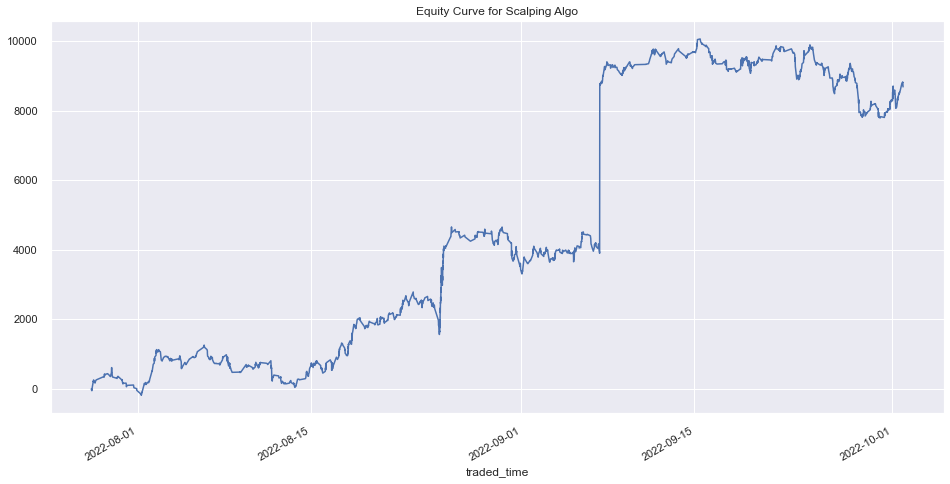

In [269]:
trading_history.set_index('traded_time').total_sreturns.plot(figsize = (16,8), title = 'Equity Curve for Scalping Algo')

In [208]:
trades / len(data.loc['2022-07-28 06:00:00+00:00': '2022-10-01 21:00:00+00:00'])

0.8225960012694383

In [254]:
def getHHI(betRet):

    if betRet.shape[0]<= 2: return np.NaN

    wght = betRet / betRet.sum()

    hhi = (wght**2).sum()

    hhi=(hhi-betRet.shape[0]**-1)/(1.-betRet.shape[0]**-1)

    return hhi

In [255]:
getHHI(trading_history.sreturns)

0.000853470081575354

In [210]:
micro_data = dataset[['order_book']]

In [211]:
def microprice(data: pd.DataFrame):
    
    df = data.copy()
    
    
    df['imb'] = df.bid_size / (df.ask_size + df.bid_size)
    df['microprice'] = df.ask * df.imb + df.bid * (1-df.imb)
    
    return df
    
    

PERFORMANCE METRICS
Terminal Wealth: -152662.96
--------------------------------------------------------------------------------
Return on Investment: -24.48
--------------------------------------------------------------------------------
Sharpe Ratio: -0.43
--------------------------------------------------------------------------------
Hit Rate: 0.33
--------------------------------------------------------------------------------
Number of Trades: 6236


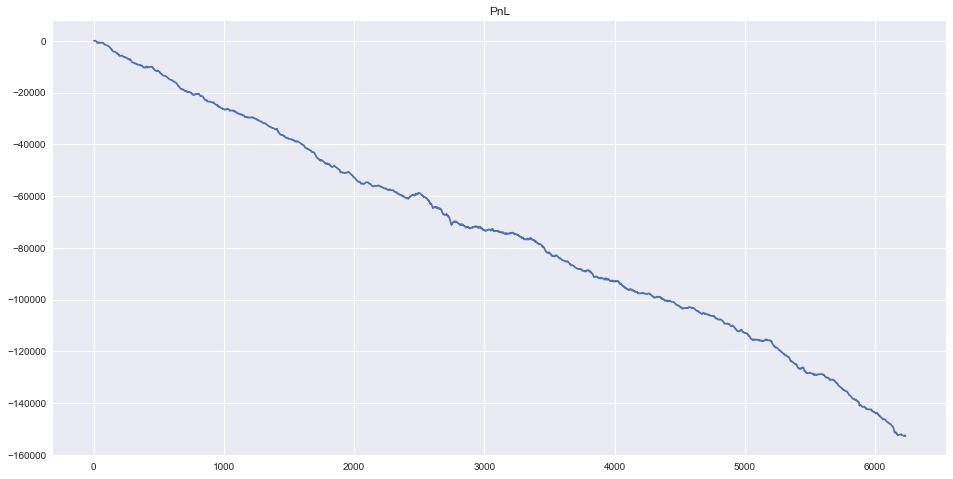

In [221]:
# Parameters

phi = 1.5
commissions = 0.025
premium = 1.025


# Algo Trackers


cashflow = 0
position = 0
trades = 0
record_trade = 0

cashflow_tracker = []
logger = []
logger_list = []

# on_data

micro_data = dataset[['order_book']].copy()

deliveries = micro_data.index


# Core Algo Rules

for delivery_time in deliveries:
    
    order_book = dataset.order_book[str(delivery_time)].dropna().copy()
    lob_ind = microprice(order_book)
    
    
    # Selling Rule
    

    for layer in range(len(order_book)-1):
            
        if (lob_ind.microprice.iloc[layer] < lob_ind.bid.iloc[layer] + phi*(lob_ind.ask.iloc[layer] - lob_ind.bid.iloc[layer]) + commissions):
                 
            if (position == 0): 
                
                cashflow += (order_book.bid.iloc[layer] + commissions)
                position = -1
                trades += 1
                record_trade = layer
                
                logger.append('Sold 1MW at {:.2f} | delivery time is {} | traded time {} '.format(order_book.bid.iloc[layer], delivery_time, order_book.index[layer]))
                #print('Sold 1MW at {:.2f} | delivery time is {} | traded time {} '.format(order_book.bid.iloc[layer], delivery_time, order_book.index[layer]))
                #time.sleep(0.005)
                logger_list.append((order_book.bid.iloc[layer], cashflow, delivery_time, order_book.index[layer], -1, position))            
                
            elif position == -1: 
                
                 if (record_trade != 0) & (order_book.bid.iloc[record_trade] > (order_book.ask.iloc[layer] + premium)):
        
                     cashflow += - (order_book.ask.iloc[layer] + commissions)
                     position = 0
                     trades += 1
                    
                     logger.append('Bought 1MW at {:.2f} | delivery time is {} | traded time {}'.format(order_book.ask.iloc[layer], delivery_time, order_book.index[layer]))
                     #print('Bought 1MW at {:.2f} | delivery time is {} | traded time {}'.format(order_book.ask.iloc[layer], delivery_time, order_book.index[layer]))
                     #time.sleep(0.005)
                     logger_list.append((order_book.ask.iloc[layer], cashflow, delivery_time, order_book.index[layer], 1, position))
                    
                 else:
                     pass
            
            
    # Buying Rule      
                    
        elif (lob_ind.microprice.iloc[layer] > lob_ind.ask.iloc[layer] - phi*(lob_ind.ask.iloc[layer] - lob_ind.bid.iloc[layer]) + commissions):
        
            if (position == 0): 
                        
                cashflow += -(order_book.ask.iloc[layer] + commissions)
                position = 1
                trades += 1
                record_trade = layer
                
                logger.append('Bought 1MW at {:.2f} | delivery time is {} | traded time {}'.format(order_book.ask.iloc[layer], delivery_time, order_book.index[layer]))
                #print('Bought 1MW at {:.2f} | delivery time is {} | traded time {}'.format(order_book.ask.iloc[layer], delivery_time, order_book.index[layer]))
                #time.sleep(0.005)
                logger_list.append((order_book.ask.iloc[layer], cashflow, delivery_time, order_book.index[layer], 1, position))
            
                        
                        
            elif position == 1:
                    
                
                 if (record_trade != 0) & (order_book.ask.iloc[record_trade] < order_book.bid.iloc[layer] + premium):
                
                     cashflow += (order_book.bid.iloc[layer] + commissions)
                     position = 0
                     trades += 1
                    
                     logger.append('Sold 1MW at {:.2f} | delivery time is {} | traded time {}'.format(order_book.bid.iloc[layer], delivery_time, order_book.index[layer]))
                     #print('Sold 1MW at {:.2f} | delivery time is {} | traded time {}'.format(order_book.bid.iloc[layer], delivery_time, order_book.index[layer]))
                     #time.sleep(0.005)
                     logger_list.append((order_book.bid.iloc[layer], cashflow, delivery_time, order_book.index[layer], -1, position))
                    
                 else:
                     pass
                    
            

    
    # Brute Force Liquidation at delivery (no cash-out)
                    
    if (position == 1): 
            
        cashflow += (order_book.bid.iloc[layer] + commissions)
        position = 0
        trades += 1
        
        logger.append('Sold 1MW at {:.2f} | delivery time is {} | traded time {}'.format(order_book.bid.iloc[layer], delivery_time, order_book.index[layer]))
        #print('1MW is Liquidated at {:.2f} | delivery time is {} | traded time {}'.format(order_book.bid.iloc[layer], delivery_time, order_book.index[layer]))
        #time.sleep(0.5)
        logger_list.append((order_book.bid.iloc[layer], cashflow, delivery_time, order_book.index[layer], -1, position))
            
    elif position == -1: 
            
        cashflow += -(order_book.ask.iloc[layer] + commissions)
        position = 0
        trades += 1
        
        logger.append('Bought 1MW at {:.2f} | delivery time is {} | traded time {}'.format(order_book.ask.iloc[layer], delivery_time, order_book.index[layer]))
        #print('1MW is Liquidated at {:.2f} | delivery time is {} | traded time {}'.format(order_book.ask.iloc[layer], delivery_time, order_book.index[layer]))
        #time.sleep(0.5)
        logger_list.append((order_book.ask.iloc[layer], cashflow, delivery_time, order_book.index[layer], 1, position))
                      
        #cashflow_tracker.append((delivery_time, cashflow, indicator[0], indicator[1]))
                
                
        
    
# Wrapping up   


trading_history = pd.DataFrame(logger_list)
trading_history.columns = ['traded_price', 'cashflow', 'delivery_time', 'traded_time', 'signal', 'position']
trading_history['returns'] = trading_history.traded_price - trading_history.traded_price.shift(1)
trading_history['sreturns'] = trading_history.signal.shift(1) * trading_history.returns
trading_history['total_sreturns'] = trading_history.sreturns.cumsum()

trading_history.total_sreturns.plot(figsize=(16,8), title = 'PnL')


terminal = trading_history.total_sreturns.iloc[-1]
rinv = trading_history.total_sreturns.iloc[-1] / len(trading_history)
sharpe = trading_history.sreturns.mean() / trading_history.sreturns.std()
hitrate = trading_history.query('sreturns > 0').shape[0] / trades


print('PERFORMANCE METRICS')
print('='*80)
print('Terminal Wealth: {:.2f}'.format(terminal))
print('-'*80)
print('Return on Investment: {:.2f}'.format(rinv))
print('-'*80)
print('Sharpe Ratio: {:.2f}'.format(sharpe))
print('-'*80)
print('Hit Rate: {:.2f}'.format(hitrate))
print('-'*80)
print('Number of Trades: {}'.format(trades))
print('='*80)




In [219]:
logger

['Bought 1MW at 237.37 | delivery time is 2022-07-28 01:00:00+00:00 | traded time 2022-07-28 00:00:17',
 'Sold 1MW at 210.00 | delivery time is 2022-07-28 01:00:00+00:00 | traded time 2022-07-28 00:44:54',
 'Bought 1MW at 232.29 | delivery time is 2022-07-28 01:30:00+00:00 | traded time 2022-07-28 00:30:19',
 'Sold 1MW at 227.50 | delivery time is 2022-07-28 01:30:00+00:00 | traded time 2022-07-28 01:14:57',
 'Bought 1MW at 248.60 | delivery time is 2022-07-28 02:00:00+00:00 | traded time 2022-07-28 01:01:03',
 'Sold 1MW at 225.01 | delivery time is 2022-07-28 02:00:00+00:00 | traded time 2022-07-28 01:44:53',
 'Bought 1MW at 249.63 | delivery time is 2022-07-28 02:30:00+00:00 | traded time 2022-07-28 01:30:19',
 'Sold 1MW at 202.00 | delivery time is 2022-07-28 02:30:00+00:00 | traded time 2022-07-28 02:14:53',
 'Bought 1MW at 218.13 | delivery time is 2022-07-28 03:00:00+00:00 | traded time 2022-07-28 02:02:54',
 'Sold 1MW at 200.00 | delivery time is 2022-07-28 03:00:00+00:00 | trad

In [222]:
df.query(f'niv >= {q[0.25]} & niv <= {q[0.5]}')

,niv,dir,consecutive,is_flip
2022-02-22 15:30:00+00:00,-25.69,-1.0,-4.0,0.0
2022-02-22 17:00:00+00:00,-41.90,-1.0,-1.0,-0.0
2022-02-22 19:00:00+00:00,-21.90,-1.0,-1.0,-0.0
2022-02-22 20:30:00+00:00,-71.66,-1.0,-1.0,-0.0
2022-02-22 21:30:00+00:00,-62.39,-1.0,-5.0,-0.0
...,...,...,...,...
2022-10-01 14:30:00+00:00,-91.51,-1.0,-13.0,1.0
2022-10-01 21:00:00+00:00,-142.45,-1.0,-2.0,-0.0
2022-10-01 21:30:00+00:00,-109.39,-1.0,-2.0,0.0
2022-10-01 23:00:00+00:00,-119.12,-1.0,-2.0,-0.0


In [256]:
def downside_risk(returns, risk_free=0):
    adj_returns = returns - risk_free
    sqr_downside = np.square(np.clip(adj_returns, np.NINF, 0))
    return np.sqrt(np.nanmean(sqr_downside) * 252)


def sortino(returns, risk_free=0):
    adj_returns = returns - risk_free
    drisk = downside_risk(adj_returns)

    if drisk == 0:
        return np.nan

    return (np.nanmean(adj_returns) * np.sqrt(252)) \
        / drisk

In [257]:
sortino(trading_history.returns)

-0.0004605628703516561

In [262]:
trading_history.query('sreturns > 0').sreturns.mean() / trading_history.query('sreturns < 0').sreturns.std()

0.7184855353567057

In [235]:
for k in range(0,101):
    
    

    print((k, np.round(np.percentile(df.niv, k),2)))

(0, -1840.81)
(1, -771.74)
(2, -659.31)
(3, -594.17)
(4, -547.04)
(5, -500.79)
(6, -472.1)
(7, -439.24)
(8, -414.79)
(9, -390.84)
(10, -370.68)
(11, -352.16)
(12, -331.93)
(13, -317.11)
(14, -301.51)
(15, -286.27)
(16, -273.71)
(17, -260.09)
(18, -248.45)
(19, -235.98)
(20, -225.21)
(21, -211.98)
(22, -202.15)
(23, -192.02)
(24, -181.99)
(25, -170.94)
(26, -160.64)
(27, -151.61)
(28, -141.46)
(29, -132.03)
(30, -124.57)
(31, -117.3)
(32, -109.41)
(33, -101.64)
(34, -93.9)
(35, -85.2)
(36, -78.49)
(37, -72.23)
(38, -65.23)
(39, -57.05)
(40, -50.67)
(41, -43.78)
(42, -37.01)
(43, -31.08)
(44, -23.71)
(45, -17.65)
(46, -10.74)
(47, -4.51)
(48, 1.41)
(49, 7.47)
(50, 14.39)
(51, 20.25)
(52, 26.16)
(53, 31.14)
(54, 37.26)
(55, 44.08)
(56, 50.46)
(57, 56.42)
(58, 62.31)
(59, 68.79)
(60, 75.41)
(61, 81.9)
(62, 88.44)
(63, 96.06)
(64, 102.51)
(65, 110.16)
(66, 116.83)
(67, 124.94)
(68, 132.81)
(69, 139.41)
(70, 146.82)
(71, 154.25)
(72, 160.76)
(73, 169.67)
(74, 178.7)
(75, 188.06)
(76, 195.7)


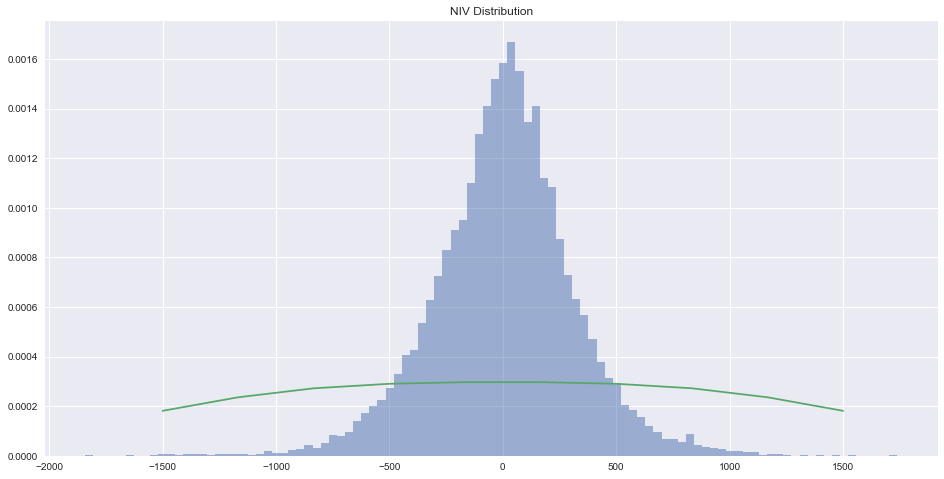

In [247]:
xx = np.linspace(-1500, 1500, 10)
kde = stats.gaussian_kde(xx) 

plt.figure(figsize=(16,8))
plt.hist(data.niv, bins = 100, density=True, alpha = 0.5)
plt.plot(xx, kde(xx))
plt.title('NIV Distribution')
plt.show()

array([-1500.        , -1166.66666667,  -833.33333333,  -500.        ,
        -166.66666667,   166.66666667,   500.        ,   833.33333333,
        1166.66666667,  1500.        ])

<AxesSubplot:xlabel='niv', ylabel='Count'>

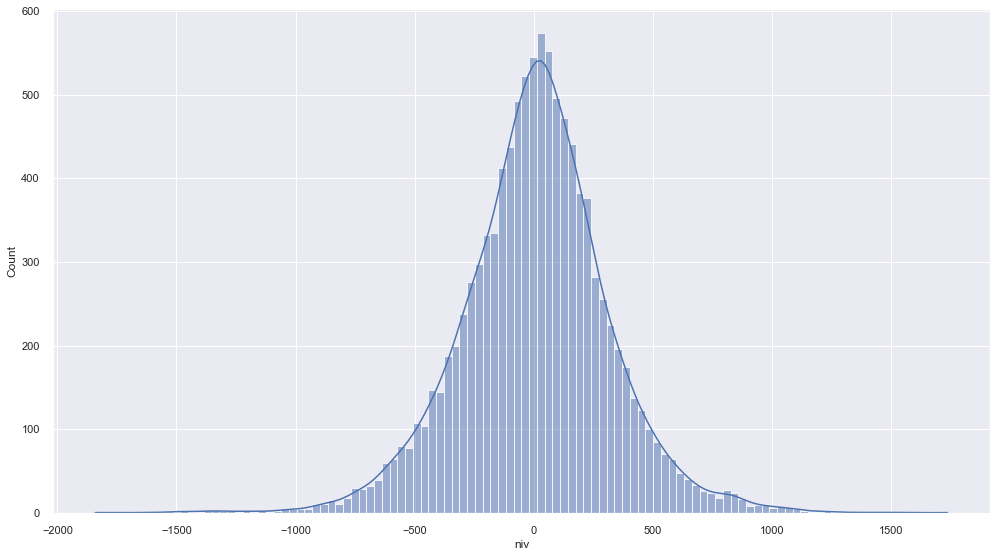

In [250]:

sns.set(rc={'figure.figsize':(16.8,9.27)})
sns.histplot(data.niv, kde=True)

<AxesSubplot:xlabel='delivery_time'>

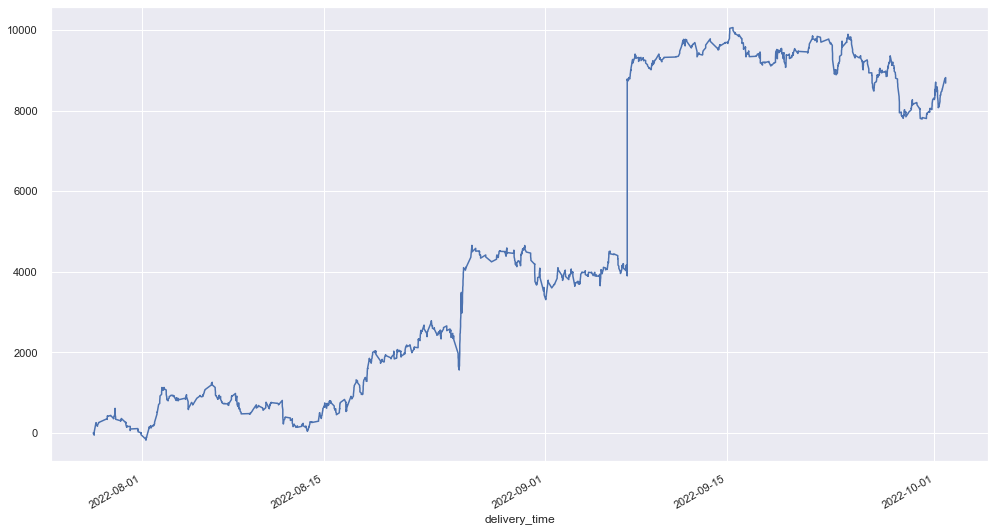

In [272]:
trading_history.set_index('delivery_time').total_sreturns.plot()

In [306]:

from numpy import datetime64, datetime_as_string, datetime_data
from pandas import DatetimeTZDtype


trading_history.delivery_time.dtype is datetime64

False

In [307]:
gre = trading_history.set_index('delivery_time')

In [320]:
len(gre.sreturns) == trades

True

In [351]:
class StrategyEvaluator():
    
    def __init__(self, data: pd.Series, rounding: int):
        
        self.data = data.to_frame('sreturns')
        self.data.dropna(inplace=True)
        self.rounding = rounding
        
        self.trades = len(data)
        
        self.get_performance()
        
        
        
    def print_performance(self):
        
        results = self.results
        
        print('PERFORMANCE METRICS')
        print('='*80)
        print('Terminal Wealth: {}'.format(results['terminal_wealth']))
        print('-'*80)
        print('Sharpe Ratio: {}'.format(results['sharpe_ratio']))
        print('-'*80)
        print('Sortino Ratio: {}'.format(results['sortino_ratio']))
        print('-'*80)
        print('Hit Rate: {}'.format(results['hit_rate']))
        print('-'*80)
        print('# Trades: {} | Wins: {} | Losses: {}'.format(self.trades, results['winners'], results['loosers']))
        print('-'*80)

        print('Average Return: {}'.format(results['avg_return']))
        print('-'*80)
        print('Median Return: {}'.format(results['median_return']))
        print('-'*80)
        print('Standard Deviation of Returns: {}'.format(results['standard_deviation']))
        print('-'*80)

        print('HHI: {} | HHI plus: {} | HHI minus: {}'.format(round(results['hhi_np'], self.rounding), round(results['hhi_pos'], self.rounding), round(results['hhi_neg'], self.rounding)))
        print('-'*80)
        print('Gain-Loss Ratio: {}'.format(results['gainloss_ratio']))
        print('-'*80)
        print('5%: {} | 33%: {} | 50%: {} | 67%: {} | 95%: {}'.format(results['q05'], results['q33'], results['q50'], results['q67'], results['q95']))
        print('-'*80)

        print('='*80)
        
    
    def plot_performance(self) -> plt.plot:
        
        return self.total_returns().plot(figsize=(16,8), title = 'Strategy Equity Curve')
    
    def plot_distribution(self) -> plt.plot:
        
        sns.set(rc={'figure.figsize':(16.8,9.27)})
        sns.histplot(self.data.sreturns, kde=True)
    
        
    def get_performance(self) -> pd.Series:
        
        terminal = self.total_returns()[-1]
        sharpe = self.sharpe_ratio()
        sortino = self.sortino_ratio()
        glos = self.gainloss_ratio()
        
        trades = self.trades
        hr = self.hit_rate()
        
        winners = self.winners()
        loosers = self.loosers()
        
        avg_rets = self.mean_returns()
        mrets = self.median_returns()
        stdev = self.stdev_returns()
        
        hhi_pos = round(self.hhi(self.data.query('sreturns > 0').sreturns), self.rounding)
        hhi_neg = round(self.hhi(self.data.query('sreturns < 0').sreturns), self.rounding)
        hhi_np = round(self.hhi(self.data.sreturns), self.rounding)
        
        quants = self.quantiles()
        
        q05 = quants[0.05]
        q33 = quants[0.33]
        q50 = quants[0.50]
        q67 = quants[0.67]
        q95 = quants[0.95]
        
        all_info = [terminal, sharpe, sortino, glos, trades, hr, winners, loosers, 
                    avg_rets, mrets, stdev, hhi_pos, hhi_neg, hhi_np, q05, q33, q50, q67, q95]
        
        infos = pd.Series(all_info)
        
        infos.index = ['terminal_wealth', 'sharpe_ratio', 'sortino_ratio', 'gainloss_ratio', 'n_trades',
                       'hit_rate', 'winners', 'loosers', 'avg_return', 'median_return', 'standard_deviation',
                       'hhi_pos', 'hhi_neg', 'hhi_np', 'q05', 'q33', 'q50', 'q67', 'q95']
        
        self.results = infos
        
            
    
        
    def total_returns(self) -> float:
        return round(self.data.sreturns.cumsum(), self.rounding)
    
    def sharpe_ratio(self) -> float:
        return round(self.data.query('sreturns != 0').sreturns.mean() / self.data.query('sreturns != 0').sreturns.std(), self.rounding)
    
    def sortino_ratio(self) -> float:
        return round(self.data.query('sreturns > 0').sreturns.mean() / self.data.query('sreturns < 0').sreturns.std(), self.rounding)
    
    def gainloss_ratio(self) -> float:
        return round(self.data.sreturns.max() / abs(self.data.sreturns.min()), self.rounding)
    
    def hit_rate(self) -> float:
        return round(self.data.query('sreturns > 0').shape[0] / self.trades, self.rounding)
    
    def winners(self) -> int:
        return self.data.query('sreturns > 0').shape[0]
    
    def loosers(self) -> int:
        return self.trades - self.winners()
    
    def mean_returns(self) -> float:
        return round(self.data.sreturns.mean(), self.rounding)
    
    def median_returns(self) -> float:
        return round(self.data.sreturns.median(), self.rounding)
    
    def stdev_returns(self) -> float:
        return round(self.data.sreturns.std(), self.rounding)
    
    def hhi(self, betRet) -> float:
    
        if betRet.shape[0]<= 2: return np.NaN

        wght = betRet / betRet.sum()

        hhi = (wght**2).sum()

        hhi=(hhi-betRet.shape[0]**-1)/(1.-betRet.shape[0]**-1)

        return hhi
    
    def quantiles(self) -> float:
        
        qs = [0.05, 0.33, 0.5, 0.67, 0.95]
        
        return round(self.data.sreturns.quantile(qs), self.rounding)
    
        
        
        
        
    

        
        
        
        

In [352]:
s = StrategyEvaluator(trading_history.set_index('traded_time').sreturns, rounding=2)
s.results

terminal_wealth       8683.77
sharpe_ratio             0.07
sortino_ratio            0.56
gainloss_ratio           0.89
n_trades              2592.00
hit_rate                 0.61
winners               1575.00
loosers               1017.00
avg_return               3.35
median_return            2.17
standard_deviation      49.24
hhi_pos                  0.00
hhi_neg                  0.00
hhi_np                   0.08
q05                    -75.74
q33                     -0.50
q50                      2.17
q67                     14.19
q95                     73.75
dtype: float64

In [353]:
s.print_performance()

PERFORMANCE METRICS
Terminal Wealth: 8683.77
--------------------------------------------------------------------------------
Sharpe Ratio: 0.07
--------------------------------------------------------------------------------
Sortino Ratio: 0.56
--------------------------------------------------------------------------------
Hit Rate: 0.61
--------------------------------------------------------------------------------
# Trades: 2592 | Wins: 1575.0 | Losses: 1017.0
--------------------------------------------------------------------------------
Average Return: 3.35
--------------------------------------------------------------------------------
Median Return: 2.17
--------------------------------------------------------------------------------
Standard Deviation of Returns: 49.24
--------------------------------------------------------------------------------
HHI: 0.08 | HHI plus: 0.0 | HHI minus: 0.0
--------------------------------------------------------------------------------
Gain

<AxesSubplot:title={'center':'Strategy Equity Curve'}, xlabel='traded_time'>

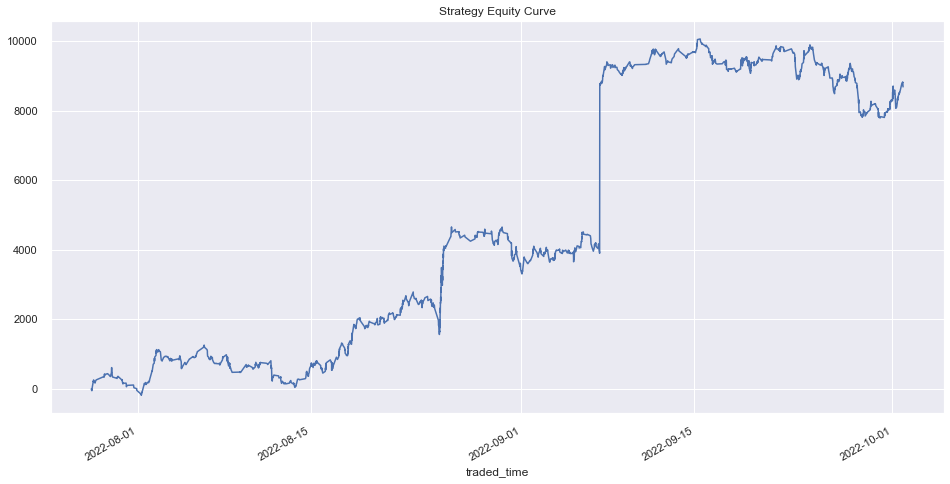

In [354]:
s.plot_performance()

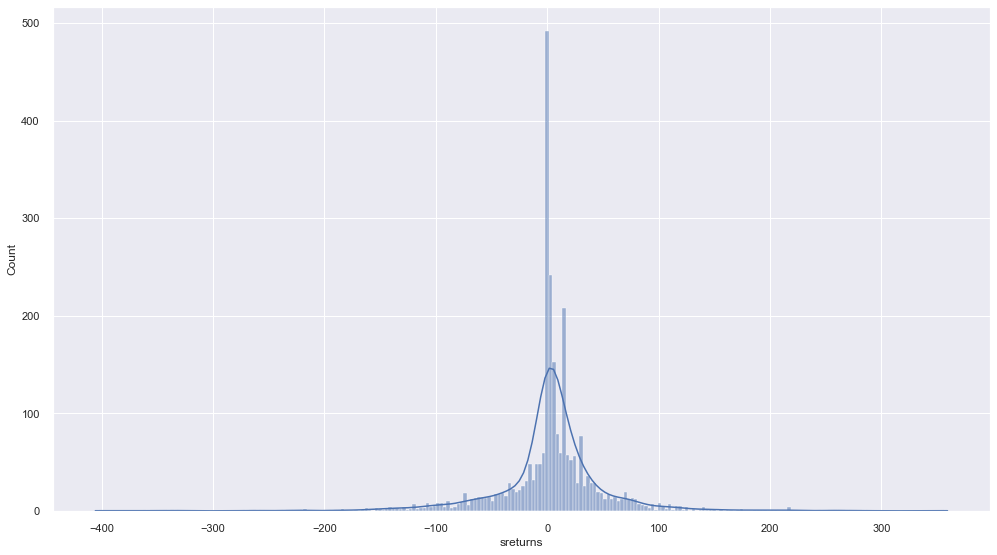

In [355]:
s.plot_distribution()

In [326]:
round(gre.sreturns.quantile(qs),2)

0.05   -75.74
0.33    -0.50
0.50     2.17
0.67    14.19
0.95    73.75
Name: sreturns, dtype: float64